# Dataset EDA - Positive Comments

To do:
- data cleaning/processing stuff (e.g. in the kaggle, also drop 'ups' column)
- univariate analyses for each column?
- bivariate analyses (score vs other columns, parent score vs child score, parent text vs child text, )
    - focus on parent text, parent score, child text, child score
- assessment of missingness?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data cleaning/preprocessing (Heavily referenced/copied from [the original kaggle notebook](https://www.kaggle.com/code/danofer/reddit-comments-scores-nlp/notebook))

In [2]:
columns = ['parent_id', 'subreddit_id', 'text', 'score',
#            'ups', 'parent_ups',  ## these appear to be redundnat with score, especially in this dataset (normally would allow info about upvotes * downvotes)
       'author', 'controversiality',  'parent_text',
       'parent_score', 'parent_author',
       'parent_controversiality']

In [3]:
positive_raw = pd.read_csv('comments_positive.csv', usecols=columns)
positive_raw.head()

,parent_id,subreddit_id,text,score,author,controversiality,parent_text,parent_score,parent_author,parent_controversiality
0,t1_c092gss,t5_2qh2p,This isn't Twitter: try to comment on the arti...,9582,nraustinii,0,Fucking faggot.,-7526,Glorificus,0
1,t1_c4im948,t5_2qh1i,"Well, it is exactly what it sounds like. It's ...",9531,Lynfect,0,"Elaborate on this cum box, please.",3841,eeeeevil,0
2,t1_c0s4lje,t5_2qh1i,"In soviet Russia, bomb disarms you!",8545,CapnScumbone,0,"I don't live in Russia anymore, and I will not...",621,shady8x,0
3,t1_c4incln,t5_2qh1i,"""runin for senitur! #YOLO!""",7430,[deleted],0,This just made me realize that future presiden...,4651,drspg99,0
4,t1_c4ima2e,t5_2qh1i,You step motherfucker.,7173,jbg89,0,I have sex with my step mom when my dad isn't ...,4251,audir8,0


## EDA

In [5]:
display(positive_raw.info())
display(positive_raw.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 10 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   parent_id                object
 1   subreddit_id             object
 2   text                     object
 3   score                    int64 
 4   author                   object
 5   controversiality         int64 
 6   parent_text              object
 7   parent_score             int64 
 8   parent_author            object
 9   parent_controversiality  int64 
dtypes: int64(4), object(6)
memory usage: 152.6+ MB


None

parent_id                  1688360
subreddit_id                  1806
text                       1944233
score                         3939
author                      515091
controversiality                 2
parent_text                1660048
parent_score                  5356
parent_author               533981
parent_controversiality          2
dtype: int64

<AxesSubplot:xlabel='parent_score', ylabel='score'>

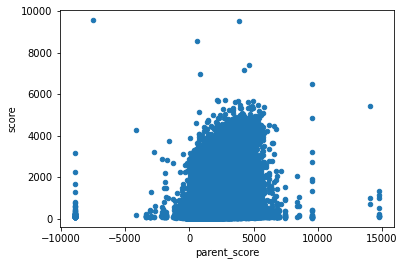

In [17]:
positive_raw.plot( x='parent_score', y='score', kind='scatter')

There doesn't seem to be a super strong correlation between parent_score and score within this dataset of high-scoring posts.

In [14]:
positive_raw.groupby('subreddit_id').mean().sort_by('score')['score'].plot()

AttributeError: 'DataFrame' object has no attribute 'sort_by'

In [6]:
print((positive_raw['score'] == positive_raw['ups']).all())

True
True


## Text processing (from [the original kaggle](https://www.kaggle.com/code/danofer/reddit-comments-scores-nlp/notebook))

In [20]:
!pip install textblob

In [33]:
import string
from string import punctuation
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
stop_words = set(stopwords.words('english')) 

# !pip install TextBlob
from textblob import TextBlob

# functions to get polatiy and subjectivity of text using the module textblob
def get_polarity(text):
    try:
        textblob = TextBlob(unicode(text, 'utf-8'))
        pol = textblob.sentiment.polarity
    except:
        pol = 0.0
    return pol

def get_subjectivity(text):
    try:
        textblob = TextBlob(unicode(text, 'utf-8'))
        subj = textblob.sentiment.subjectivity
    except:
        subj = 0.0
    return subj


def tag_part_of_speech(text):
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    pos_list = pos_tag(text_splited)
    noun_count = len([w for w in pos_list if w[1] in ('NN','NNP','NNPS','NNS')])
    adjective_count = len([w for w in pos_list if w[1] in ('JJ','JJR','JJS')])
    verb_count = len([w for w in pos_list if w[1] in ('VB','VBD','VBG','VBN','VBP','VBZ')])
    return[noun_count, adjective_count, verb_count]

def text_features(df:pd.DataFrame,text:str="text", get_pos_feats=False,get_textblob_sentiment=True) -> pd.DataFrame:
    """
    Extract and add in place many text/NLP features on a pandas dataframe for a given column.
    Functions are generic, but some were basedon  :  https://www.kaggle.com/shivamb/extensive-text-data-feature-engineering , 
    https://www.kaggle.com/shaz13/feature-engineering-for-nlp-classification
    Modified to use vectorized functions.
    """
    # https://www.kaggle.com/shaz13/feature-engineering-for-nlp-classification
    df[f'{text}_char_count'] = df[text].str.len()
    df[f'{text}_num_words'] = df[text].str.split().str.len()

    df['capitals'] = df[text].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row[f'{text}_char_count']),axis=1)
    df['num_exclamation_marks'] = df[text].str.count('!')
    df['num_question_marks'] = df[text].str.count('\?')
    df['num_punctuation'] = df[text].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
    df['num_symbols'] = df[text].apply(lambda comment: sum(comment.count(w) for w in r'*&$%/:;'))

    df['num_unique_words'] = df[text].apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df[f'{text}_num_words']
    df['num_smilies'] = df[text].apply(lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))
    df['num_sad'] = df[text].apply(lambda comment: sum(comment.count(w) for w in (':-<', ':()', ';-()', ';(')))

#     df['char_count'] = df['text'].apply(len)
#     df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    df['word_density'] = df[f'{text}_char_count'] / (df[f'{text}_num_words']+1)
    df['punctuation_count'] = df['text'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 

    df['upper_case_word_count'] = df[text].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
    df['stopword_count'] = df[text].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_words]))
#     df['title_word_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
    df["count_words_title"] = df[text].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    df["mean_word_len"] = df[text].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    df['punct_percent']= df['num_punctuation']*100/df[f'{text}_num_words']
    
    if get_textblob_sentiment:
        df['polarity'] = df[text].apply(get_polarity)
        df['subjectivity'] = df[text].apply(get_subjectivity)
    
    if get_pos_feats:
        df['nouns'], df['adjectives'], df['verbs'] = zip(*df[text].apply(
            lambda comment: tag_part_of_speech(comment)))
        df['nouns_vs_length'] = df['nouns'] / df[f'{text}_char_count']
        df['adjectives_vs_length'] = df['adjectives'] / df[f'{text}_char_count']
        df['verbs_vs_length'] = df['verbs'] /df[f'{text}_char_count']
        df['nouns_vs_words'] = df['nouns'] / df[f'{text}_num_words']
        df['adjectives_vs_words'] = df['adjectives'] / df[f'{text}_num_words']
        df['verbs_vs_words'] = df['verbs'] / df[f'{text}_num_words']

        df.drop(['nouns','adjectives','verbs'],axis=1,inplace=True) # drop the count of POS, keep only the percentages. Can change to keep them..

        
    df["ends_on_alphanumeric"] = df[text].str.strip().str[-1].str.isalpha() # does word end on alphanumeric, vs ".". Interesting for comments. Note the strip. 
        
    return df

In [28]:
positive_raw[['text']].astype(str)

,text
0,This isn't Twitter: try to comment on the arti...
1,"Well, it is exactly what it sounds like. It's ..."
2,"In soviet Russia, bomb disarms you!"
3,"""runin for senitur! #YOLO!"""
4,You step motherfucker.
...,...
1999995,"yeah man, those things are bad for your health."
1999996,I honestly like this because it asks the other...
1999997,Is... that what you see here?
1999998,Prepare to lose your breakfast. Entire school ...


In [34]:
positive_text = positive_raw[['text']].astype(str)
positive_text = text_features(positive_text, get_pos_feats=True)
positive_text.head()

C:\Users\eviye\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


,text,text_char_count,text_num_words,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,num_unique_words,...,punct_percent,polarity,subjectivity,nouns_vs_length,adjectives_vs_length,verbs_vs_length,nouns_vs_words,adjectives_vs_words,verbs_vs_words,ends_on_alphanumeric
0,This isn't Twitter: try to comment on the arti...,83,14,2,0.024096,0,0,3,1,14,...,21.428571,0.0,0.0,0.060241,0.012048,0.012048,0.357143,0.071429,0.071429,False
1,"Well, it is exactly what it sounds like. It's ...",1746,329,57,0.032646,0,1,62,13,213,...,18.844985,0.0,0.0,0.036655,0.013173,0.037228,0.194529,0.069909,0.197568,False
2,"In soviet Russia, bomb disarms you!",35,6,2,0.057143,1,0,1,0,6,...,16.666667,0.0,0.0,0.085714,0.028571,0.000000,0.500000,0.166667,0.000000,False
3,"""runin for senitur! #YOLO!""",27,4,4,0.148148,2,0,0,0,4,...,0.000000,0.0,0.0,0.111111,0.000000,0.000000,0.750000,0.000000,0.000000,False
4,You step motherfucker.,22,3,1,0.045455,0,0,1,0,3,...,33.333333,0.0,0.0,0.000000,0.045455,0.045455,0.000000,0.333333,0.333333,False
